# Linear Discriminant Analysis

## Introdução

O Churn é fenômeno que se caracteriza pelo abandono de uma empresa por um cliente, por exemplo, quando correntistas de um banco encerram suas contas. Este é um problema bastante comum entre as empresas prestadores de serviços e em geral refletem um desempenho ruim da empresa. Frequentemente é trabalho do time de Data Science a avalianção das causas e a indicação de estratégias para prevenção do churn. 

Neste contexto, uma base de dados disponível publicamente é a base de Churn da Telco, tanto no [kaggle](https://www.kaggle.com/blastchar/telco-customer-churn), quanto no git da [ibm](https://github.com/IBM/telco-customer-churn-on-icp4d/tree/master/data).

## Imports

In [1]:
# Importando pacotes necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors

from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn import datasets  
from sklearn.model_selection import train_test_split, KFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import (classification_report, accuracy_score, precision_score, 
                             recall_score, f1_score)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")

## Telco Churn Dataset
### Read

In [2]:
telco_churn = pd.read_csv('C:/Users/Gustavo/Py Projects/EXERCICIO LDA/DATA/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
telco_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Feature Engineering

Uma limitação do LDA é a necessidade de entradas numéricas, nesse sentido é necessário converter todas as variáveis categóricas.

Alésm disso existem variáveis que não são desejáveis, como o customerID, que precisam ser removidas.

In [4]:
telco_churn.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [5]:
#Excluindo colunas desnecessárias
telco_churn.drop(['customerID'], axis=1, inplace=True)

In [6]:
# Transformando dados de colunas booleanas em booleans 
BOOLEAN_COLUMNS = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                   'PhoneService', 'PaperlessBilling', 'Churn']
telco_churn[BOOLEAN_COLUMNS] = telco_churn[BOOLEAN_COLUMNS].replace(['No', 'Yes', 'Male', 'Female'], [0.0,1.0,0.0,1.0])

In [7]:
# Transformando dados de colunas categoricas em booleans categorias
CATEGORICAL_COLUMNS = ['MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract','PaymentMethod']

enc = OneHotEncoder(sparse=False)
out = enc.fit_transform(telco_churn[CATEGORICAL_COLUMNS])

telco_churn.drop(CATEGORICAL_COLUMNS, axis=1, inplace=True)

telco_churn[enc.get_feature_names(CATEGORICAL_COLUMNS)] = pd.DataFrame(out, columns=enc.get_feature_names(CATEGORICAL_COLUMNS))

In [8]:
# Transformando colunas númericas em números(float)
telco_churn['TotalCharges'] = pd.to_numeric(telco_churn['TotalCharges'], errors='coerce')
telco_churn.dropna(inplace=True)


In [9]:
# Selecionando dados de treino e teste e escalando-os
y = telco_churn['Churn']
X = telco_churn.drop('Churn', axis=1)
target_names = ['No', 'Yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Standardize data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [10]:
# LDA
lda_clf = LinearDiscriminantAnalysis(n_components=1, store_covariance=True)
lda_clf.fit(X_train, y_train)

y_pred = lda_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names))

Accuracy: 0.7846481876332623
              precision    recall  f1-score   support

          No       0.84      0.88      0.86      1033
         Yes       0.61      0.53      0.57       374

    accuracy                           0.78      1407
   macro avg       0.72      0.70      0.71      1407
weighted avg       0.78      0.78      0.78      1407



In [11]:
# Validação cruzada
kf = KFold(n_splits=5, shuffle=True)
labels = np.array(target_names)
n_components = min(X.shape[1],labels.shape[0])
accuracy = []
precision = []
recall = []
f1 = []

accuracy = []
precision = []
recall = []
f1 = []

for n in range(1,(n_components+1)):
    acc = []
    prec=[]
    rec = []
    f1_aux=[]
    for train_index, validation_index in kf.split(X):

        # Standardize data
        sc = StandardScaler()
        X_train = sc.fit_transform(X.iloc[train_index])
        X_validation = sc.transform(X.iloc[validation_index])


        lda_clf = LinearDiscriminantAnalysis(n_components=1)
        lda_clf.fit(X_train, y.iloc[train_index])

        y_validation = lda_clf.predict(X_validation)

        acc.append(accuracy_score(y.iloc[validation_index], y_validation))
        prec.append(precision_score(y.iloc[validation_index], y_validation, average=None))
        rec.append(recall_score(y.iloc[validation_index], y_validation, average=None))
        f1_aux.append(f1_score(y.iloc[validation_index], y_validation, average=None))
    accuracy.append(acc) 
    precision.append(prec)
    recall.append(rec)
    f1.append(f1_aux)

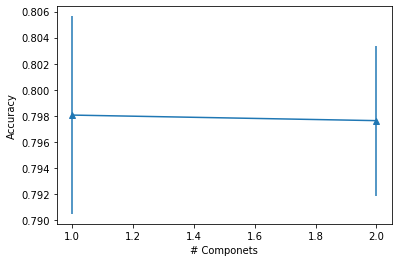

In [12]:
# Podemos observar que o menor desvio padrão da acurácia se da com número de componentes = 1
accuracy = np.array(accuracy)
mean = accuracy.mean(axis=1)
std = accuracy.std(axis=1)
plt.figure()
plt.errorbar(range(1,n_components+1), mean, std, marker='^')
plt.xlabel('# Componets')
plt.ylabel('Accuracy')
plt.show()

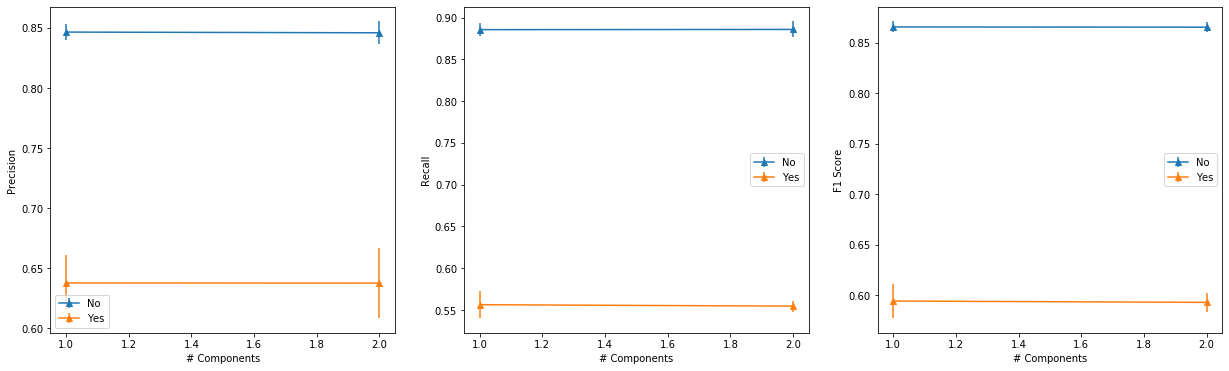

In [13]:
# Podemos observar que a taxa de precision(85% das vezes que o modelo preveu "No" e acertou), 
# recall(89% dos dados "No" foram previstos corretamente) e logo f1 score(média harmonica entre precision e recall)
# é muito maior para a classe "No" 
# e desviam pouco em relação a quantidade de componentes.
# Já para a classe "Yes" as métricas de previsão foram bem inferiores, 
# com maior desvio dependendo da quantidade de componentes.
fig, axs = plt.subplots(1,3, figsize=(21, 6))
metrics = [precision, recall, f1]
metrics_names = ['Precision', 'Recall', 'F1 Score']

for i in range(len(metrics)):
    metric = np.array(metrics[i])
    mean = metric.mean(axis=1)
    std = metric.std(axis=1)

    
    for classes in range(len(labels)):
        axs[i].errorbar(range(1,n_components+1), 
                        mean[:,classes], 
                        std[:,classes], 
                        label=labels[classes], 
                        marker='^')

    axs[i].set_xlabel('# Components')
    axs[i].set_ylabel(metrics_names[i])
    axs[i].legend()